# Aggressivity analysis
## Who are the driver of the polarization?

### Setup

In [1]:
# Notebook config
%config Completer.use_jedi = False

In [2]:
# Built-in
import os
from IPython.display import display

# Third parties
import numpy as np
import pandas as pd
import nltk
from nltk import tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [76]:
# Initialization needed for some modules

# Matplotlib's theme
plt.style.use("seaborn")

# tqdm for pandas
tqdm.pandas()

# NLTK configuration
nltk.download('vader_lexicon')
nltk.download('stopwords')
sia = SentimentIntensityAnalyzer()

# TokenSpace initialization
tokenSpace = tokenize.WhitespaceTokenizer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/olivier/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/olivier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Configuration
DATA_PATH = "data"
PKL_PATH = os.path.join(DATA_PATH, "pkl")
CSV_PATH = os.path.join(DATA_PATH, "csv")
RESOURCES_PATH = os.path.join(DATA_PATH, "resources")

In [5]:
# Utils functions

def get_sentiment(row: pd.Series) -> pd.Series:
    """
    Compute the sentiment score of a given row
    """   
    
    row['NLTK_score'] = sia.polarity_scores(row['quotation'])
    return row

def counter(text, columnText, quantity, label):
    allWords = ' '.join([text for text in text[columnText].astype('str')])
    tokenPhrase = tokenSpace.tokenize(allWords)
    frequency = nltk.FreqDist(tokenPhrase) 
    dfFrequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())}) 
    
    dfFrequency = dfFrequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(15,3))
    ax = sns.barplot(data = dfFrequency, x = "Word", y = "Frequency", palette="deep")
    ax.set(ylabel = "Count")
    plt.xticks(rotation='horizontal')
    plt.title(f"Most common words for {label}")
    plt.show()

In [6]:
# Load df
df = pd.read_pickle(os.path.join(PKL_PATH, "final_subset.pkl"))

### For windows users :
# from pickle5 import pickle
# with open("data/pkl/final_subset.pkl", "rb") as fh:
#   df = pickle.load(fh)

In [7]:
display(df.info())
df.sample(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105929 entries, 0 to 6361
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   quoteID               105929 non-null  object 
 1   quotation             105929 non-null  object 
 2   speaker               105929 non-null  object 
 3   qids                  105929 non-null  object 
 4   date                  105929 non-null  object 
 5   numOccurrences        105929 non-null  float64
 6   probas                105929 non-null  object 
 7   urls                  105929 non-null  object 
 8   phase                 105929 non-null  object 
 9   subset                105929 non-null  bool   
 10  id                    82439 non-null   object 
 11  givenName             105929 non-null  object 
 12  familyName            105929 non-null  object 
 13  unaccentedGivenName   105929 non-null  object 
 14  unaccentedFamilyName  105929 non-null  object 
 15  bi

None

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,subset,...,honorificPrefix,honorificSuffix,position,stateName,parties,NLTK score,neg,neu,pos,compound
6409,2015-10-02-107106,very tough and can negotiate with the democrats.,donald trump,"['Q22686', 'Q27947481']",2015-10-02 16:09:05,1.0,"[['Donald Trump', '0.8657'], ['None', '0.1091'...",['http://dailycaller.com/2015/10/02/trump-mcca...,E,True,...,NaN,NaN,President,NaN,Republican,"{'neg': 0.204, 'neu': 0.796, 'pos': 0.0, 'comp...",0.204,0.796,0.000,-0.2006
14449,2019-01-09-086142,the second ones (to hit me) would be the house...,president donald trump,['Q22686'],2019-01-09 19:29:08,16.0,"[['president Donald Trump', '0.9252'], ['None'...",['https://kpax.com/cnn-us-politics/2019/01/09/...,E,True,...,NaN,NaN,President,NaN,Republican,"{'neg': 0.0, 'neu': 0.899, 'pos': 0.101, 'comp...",0.000,0.899,0.101,0.4019


### 3.4 Aggressivity by speaker analysis

This section answers the question: "Which politicians are the least or the most aggressive?". We should strongly emphasize the fact that we consider a politician as being "aggressive" if she or he has an overall negative sentiment score, which is quite a shortcut. Unfortunately, the scope of the project did not allow us to provide a semantic analysis of the quotes to see if a negative quote also means, on average, that the vocabulary used and the speaker are more aggressive.

Let us start by simply analyzing the most negative scores for all speakers throughout the whole dataset.

In [19]:
most_agg = df.groupby(["speaker", "parties"]).agg({
    "compound": "mean",
    "speaker": "size", 
}) \
.rename({"speaker": "quotes_count"}, axis=1) \
.sort_values("compound")

As we can see, most extremely negative (and thus aggressive by our methodology) speakers are such because they only have one quote to their names. So we will only consider those with at least 100 quotes.

In [20]:
most_agg = most_agg[most_agg["quotes_count"] >= 100]
# Only keep those really negative
threshold = -0.05
most_agg = most_agg[most_agg["compound"] <= threshold].sort_values("compound")
most_agg

,,compound,quotes_count
speaker,parties,,
barbara lee,Democrat,-0.211459,182
tulsi gabbard,Democrat,-0.139305,332
joe walsh,Republican,-0.096052,105
elijah cummings,Democrat,-0.095461,936
maxine waters,Democrat,-0.090463,480
bennie thompson,Democrat,-0.087981,129
pramila jayapal,Democrat,-0.073166,270
claudia tenney,Republican,-0.070770,117
john yarmuth,Democrat,-0.070638,226


In [21]:
# Compute count and proportion by party
g = pd.DataFrame(most_agg.groupby("parties").size()).rename({0: "count"}, axis=1)
g["proportion"] = g["count"] / g["count"].sum()
g

,count,proportion
parties,,
Democrat,14,0.823529
Republican,3,0.176471


It clearly came as a surprise to us that the democrats seems to be the most aggressive ones when mentioning another politician from the other party. In the next section, we focus on the 3 most aggressive speakers.

#### EDA of most aggressive speakers

It seems that the following speakers are specifically negative and thus, polarizing when they are mentioning people of the other political camp:
- [Barbara Lee](https://en.wikipedia.org/wiki/Barbara_Lee) (Democrat)
- [Tulsi Gabbard](https://en.wikipedia.org/wiki/Tulsi_Gabbard) (Democrat)
- [Joe Walsh](https://en.wikipedia.org/wiki/Joe_Walsh_(Illinois_politician)) (Republican)

To explore that, let us explore a few random quotes from them.

In [13]:
speakers = ["barbara lee", "tulsi gabbard", "joe walsh"]

for speaker in speakers:
    print("Samples from", speaker)
    quotes = df[df["speaker"] == speaker].sample(3)[["quoteID", "compound", "quotation"]].values
    for q in quotes:
        print(f"QID: {q[0]}, Score: {q[1]} \n \"{q[-1]}\"\n")
    print("-" * 30)

Samples from barbara lee
QID: 2019-03-28-076070, Score: -0.8316 
 "president trump doesn't have a license to blackmail universities. he's the president, not a dictator, and his empty threats are an abuse of power,"

QID: 2017-07-19-085209, Score: 0.0 
 "over the years, i've seen republican leadership deploy every manner of undemocratic, underhanded tactics in congress,"

QID: 2016-02-17-105899, Score: 0.0 
 "the decision of budget committee republicans to reject the president's budget -- sight unseen, without even a hearing -- further shows that congressional republican are glued to their extremist, tea party agenda."

------------------------------
Samples from tulsi gabbard
QID: 2019-10-15-017382, Score: 0.34 
 "donald trump has the blood of the kurds on his hand -- but so do many of the politicians in our country from both parties who have supported this ongoing regime-change war in syria that started in 2011, along with many in the mainstream media, who have been championing and ch

By doing that multiple times (we only extracted 3 quotes by politican here), we can observe a few things. First, our method seems to capture well the polarization between the two political camps:
- Tulsi Gabbard (QID: 2019-09-25-056870, Score: -0.3182):
> it's important that donald trump is defeated,
- Barbara Lee (QID: 2015-09-16-064526 Score: -0.743):
> it's past time that republicans stop governing by crisis,
- Joe Walsh (QID: 2019-08-24-040425, Score: -0.3818):
> the truth: as practiced by most muslims, islam is not a religion. these muslims are at war w us. barack obama, a muslim, is on their side,

In some cases, though, this process outlined some clear problems:
- Barbara Lee (QID: 2020-04-16-025948 Score: **0.8074**)
>instead of giving relief to americans who are struggling to make ends meet, senate republicans snuck in tax breaks and corporate giveaways for their wealthy friends,
    - This quote should be negative and is a clear example of polarizing quote. It is not detected as such by our algorithm.
- Tulsi Gabbard (QID: 2019-04-30-091725, Score: -0.4927)
> the most attacks i get are not from republicans,
    - Although she mentions republicans, this quote is actually in favor of them, but is actually _in favor_ of republicans.
    
Those are just some examples that we wanted to outline to show some shortcomings of our algorithm. Those points could be further investigated in future work.

Now that we analyzed the aggressivity in bulk, chapter 3.1 of this notebook indicated that there seems to be a great change through the years. So we now do a similar analysis of the most aggressive speakers per year.


#### Most aggressive speakers by year

By using the same methodology as the previous point, we extract only the most aggressive speakers with at least 100 quotes and with a mean score of at least -0.05.

In [22]:
# create new "year" column in df
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

In [23]:
# Sanity check
df.sample(1)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,subset,...,honorificSuffix,position,stateName,parties,NLTK score,neg,neu,pos,compound,year
12351,2019-01-09-072676,shut down for one reason and one reason only: ...,president trump,['Q22686'],2019-01-09,1.0,"[['President Trump', '0.7978'], ['None', '0.20...",['https://www.aim.org/aim-column/trump-speech-...,E,True,...,NaN,President,NaN,Republican,"{'neg': 0.12, 'neu': 0.88, 'pos': 0.0, 'compou...",0.12,0.88,0.0,-0.2584,2019


In [24]:
most_agg = df.groupby(["year", "speaker", "parties"]).agg({
    "compound": "mean",
    "speaker": "size", 
}) \
.rename({"speaker": "quotes_count"}, axis=1) \
.sort_values("compound")

most_agg = most_agg[most_agg["quotes_count"] >= 100]
# Only keep those really negative
threshold = -0.05
most_agg = most_agg[most_agg["compound"] <= threshold].sort_values("year")

In [25]:
# Display table
most_agg

compound  quotes_count
year speaker                  parties                           
2015 elijah cummings          Democrat   -0.339667           201
2016 elijah cummings          Democrat   -0.188794           132
     donald trump             Republican -0.052753          4094
2017 jeff flake               Republican -0.111487           133
     ted lieu                 Democrat   -0.077877           100
     cory booker              Democrat   -0.078286           132
     jeanne shaheen           Democrat   -0.056756           100
     barbara lee              Democrat   -0.232446           104
     kirsten gillibrand       Democrat   -0.074496           156
     maxine waters            Democrat   -0.114713           180
2018 orrin hatch              Republican -0.075000           137
     ted lieu                 Democrat   -0.061465           109
     dianne feinstein         Democrat   -0.083949           318
     mazie hirono             Democrat   -0.119052           102
     kirsten gillibrand       Democrat   -0.120604           140
     maxine waters            Democrat   -0.122643           164
     adam smith               Democrat   -0.054608           106
     jerrold nadler           Democrat   -0.116621           131
     richard blumenthal       Democrat   -0.072185           227
2019 president donald trump   Republican -0.057747          3823
     devin nunes              Republican -0.062832           476
     kamala harris            Democrat   -0.054848           169
     xavier becerra           Democrat   -0.173166           116
     rashida tlaib            Democrat   -0.054251           107
     elise stefanik           Republican -0.097369           157
     mo brooks                Republican -0.120918           171
     tulsi gabbard            Democrat   -0.126019           205
     john ratcliffe           Republican -0.129743           117
     alexandria ocasio-cortez Democrat   -0.082365           279
     donald trump             Republican -0.080294           987

In [26]:
g = pd.DataFrame(most_agg.groupby(["year", "parties"]).size()).rename({0: "count"}, axis=1)
g["proportion"] = g["count"] / g.groupby("year")["count"].sum()
g

count  proportion
year parties                      
2015 Democrat        1    1.000000
2016 Democrat        1    0.500000
     Republican      1    0.500000
2017 Democrat        6    0.857143
     Republican      1    0.142857
2018 Democrat        8    0.888889
     Republican      1    0.111111
2019 Democrat        5    0.454545
     Republican      6    0.545455

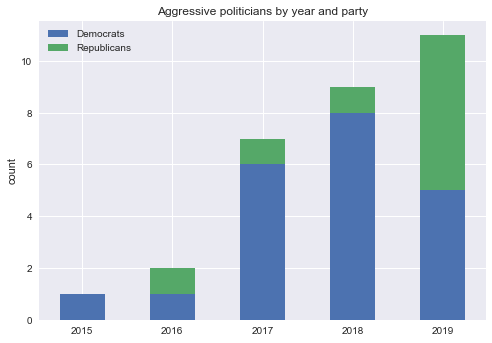

In [84]:
# Plot aggressive politicians count per year
fig, ax = plt.subplots()

labels = g.index.get_level_values(0).unique()
demo_count = g.xs("Democrat", level=1, drop_level=True)["count"].tolist()
rep_count = g.xs("Republican", level=1, drop_level=True)["count"].tolist()
rep_count.insert(0, pd.Series({2015: 0}))  # because no rep. obsevation in 2015
width = 0.5

ax.bar(labels, demo_count, width, label="Democrats")
ax.bar(labels, rep_count, width, bottom=demo_count,
       label="Republicans")

ax.set_ylabel("count")
ax.set_title("Aggressive politicians by year and party")
ax.legend()

fname = f"./figures/3.4.aggressivity_year_party.png"
plt.savefig(fname)

plt.show()

The first thing we observe is that we have only one speaker denoted as "aggressive" in 2015. This comes from the fact that we have fewer quotes in earlier year (2015 and 2016, see section 3.1). Also, it appears that we did not have enough data in 2020 to extract meaningful insights. 

In 2017 and 2018, aggressive speakers are overwhelmingly democrats. Only one republican is denoted as aggressive. In 2019, we have an exact parity between democrats and republicans. Indeed, Donald Trump is counted twice, once under "donald trump" and once under "president donald trump". 

From the most aggressive table, we clearly see that something seems to have happened around 2016 (Trump's election?) which seems to have (1) greatly increased the number of quotes about the other camp by politicians and, (2) greatly increased the number of aggressive speakers (democrats in that case). In 2019, republicans **seem to have responded to that aggressivity** by also being aggressive. We will continue to explore the evolution of the score around key events in the next section.  